# Overview of BasicHullWhite

The [Hull-White model](https://en.wikipedia.org/wiki/Hull%E2%80%93White_model) is a short rate model represented by the stochastic differential equiation:

 $$dr(t) = (\theta(t) - a r(t))dt + \sigma dW$$


`BasicHullWhite` in the **economic** library is a simple implementation of the Hull-White model built using [modelx](https://github.com/fumitoh/modelx).

`BasicHullWhite` preforms Monte-Carlo simulations and generates paths of the instantaneous short rate based on the Hull-White model. It also inclues formulas to calculate various properties of the Hull-White model.

[Gouthaman Balaraman] presents some tests performed on a Hull-White model. He uses QuantLib to build his model, but the `BasicHullWhite` does not use QuantLib, and its Monte-Carlo simulations are generated from first principles using random numbers following the standard normal distribution. 
In addition, `BasicHullWhite` generates values of stochastic variable at each time step at once as a numpy array based on the vector modeling approach.

This notebook aims to perform analyses similar to Balaraman's using `BasicHullWhite`.  


[Gouthaman Balaraman]: http://gouthamanbalaraman.com/blog/hull-white-simulation-quantlib-python.html


<div class="alert alert-block alert-info">
    
**References**

* [Gouthaman Balaraman. Hull White Term Structure Simulations with QuantLib Python](http://gouthamanbalaraman.com/blog/hull-white-simulation-quantlib-python.html)
* [Gouthaman Balaraman. On the Convergence of Hull White Monte Carlo Simulations](http://gouthamanbalaraman.com/blog/hull-white-simulation-monte-carlo-convergence.html)    
* [Damiano Brigo, Fabio Mercurio (2006). Interest Rate Models - Theory and Practice with Smile, Inflation and Credit, 2nd ed.](https://link.springer.com/book/10.1007/978-3-540-34604-3)
* [Paul Glasserman (2003). Monte Carlo Methods in Financial Engineering](https://link.springer.com/book/10.1007/978-0-387-21617-1)


</div>




Click the badge below to run this notebook online on Google Colab. You need a Google account and need to be logged in to it to run this notebook on Google Colab.
[![Run on Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lifelib-dev/lifelib/blob/current/lifelib/libraries/economic/hull-white-simulation.ipynb)


The next code cell below is relevant only when you run this notebook on Google Colab. It installs lifelib and creates a copy of the library for this notebook.

In [1]:
import sys, os

if 'google.colab' in sys.modules:
    lib = 'economic'; lib_dir = '/content/'+ lib
    if not os.path.exists(lib_dir):
        !pip install lifelib
        import lifelib; lifelib.create(lib, lib_dir)
        
    %cd $lib_dir

## Overview of the model

`HullWiteModel` include only one space, which is named `HullWhite`, and all the definitions are in that space. The `HullWhite` space is assined to `HW` in this notebook.

In [2]:
import matplotlib.pyplot as plt
import modelx as mx

model = mx.read_model('BasicHullWhite')
HW = model.HullWhite

All the input parameters except for the initial curve are given as *References* (names starting with "_" are default names defined by modelx). 

In [3]:
HW.refs

{__builtins__,
 _self,
 _space,
 np,
 step_size,
 time_len,
 a,
 sigma,
 seed1,
 seed2,
 scen_size}

The defalut values for the number of scenarios, length of time ($T$), number of steps, $a$, $\sigma$ are set equal to the Balaraman's example.

In [4]:
print("Number of scenarios:", HW.scen_size)
print("Length of time (in years):", HW.time_len)
print("Number of steps:", HW.step_size)
print("a:", HW.a)
print("sigma:", HW.sigma)

Number of scenarios: 1000
Length of time (in years): 30
Number of steps: 360
a: 0.1
sigma: 0.1


Below is a list of cells defined in `HW`. 

In [5]:
HW.cells

{A_t_T,
 B_t_T,
 E_rt,
 E_rt_s,
 P_t_T,
 V_t_T,
 Var_rt,
 Var_rt_s,
 accum_short_rate,
 accum_short_rate2,
 alpha,
 disc_factor,
 disc_factor_paths,
 mean_disc_factor,
 mean_short_rate,
 mkt_fwd,
 mkt_zcb,
 short_rate,
 short_rate_paths,
 std_norm_rand,
 t_,
 var_short_rate}

Time-dependent functions are paremeterized with integer indexes instead of times themselves, 
i.e. $f(t)$ where $t=t_i, i=1, 2, 3, \ldots$ in math expression is translated as `f(i)`, `i=1, 2, 3...` in modelx formula.
Mapping $i$ to $t_i$ is done by `t_(i)`. By defalut, $t_i$s are evenly spaced, but the model should work even if the intervals are set uneven.

In [6]:
HW.t_.formula

lambda i: i * time_len / step_size

By default, the instanteneous forward rates observed at time 0 ($f^M(0, t_i)$) are set to 0.05 in `mkt_fwd` to be consistent with the Balaraman's example. $P^M(0, t_i)$, the market prices of zero-coupon bonds by duration are calculated from $f^M(0, t_i)$ in `mkt_zcb`. These may be defined the other way around, i.e. $f^M(0, t_i)$ may be derived from $P^M(0, t_i)$ inputs. The forward rates don't have to be constant.

In [7]:
HW.mkt_fwd.formula

def mkt_fwd(i):
    """The initial instantaneous forward rate for :attr:`t_(i)<t_>`.

    By default, returns 0.05 for all ``i``.
    """
    return 0.05

In [8]:
HW.mkt_zcb.formula

def mkt_zcb(i):
    """The initial price of zero coupon bond

    The initial price of the unit zero coupon bond maturing at :attr:`t_(i)<t_>`.

    If ``i=0`` returns 1. Otherwise, defined as::

        mkt_zcb(i-1) * np.exp(-mkt_fwd(i-1)*dt)

    where ``dt = t_(i) - t_(i-1)``.

    .. seealso::
        * :attr:`t_`
        * :attr:`mkt_fwd`
    """
    if i == 0:
        return 1.0
    else:
        dt = t_(i) - t_(i-1)
        return mkt_zcb(i-1) * np.exp(-mkt_fwd(i-1)*dt)

`short_rate` corresponds to $r(t_{i})$, and recursively calculates stochastic paths of the instantaneous short rate at each time step.

In [9]:
HW.short_rate.formula

def short_rate(i):
    r"""Stochastic short rates at :attr:`t_(i)<t_>`

    Returns, in a numpy array, simulated stochastic short rates at :attr:`t_(i)<t_>`
    for all scenarios.

    For ``i=0``, defined as :meth:`mkt_fwd(0)<mkt_fwd>`.

    For ``i>0``, defined as
    :math:`r(t_i) = E\{r(t_i) | \mathcal{F}_{i-1}\} + \sqrt{Var\{ r(t_i) | \mathcal{F}_{i-1} \}} * Z`,

    where :math:`E\{r(t_i) | \mathcal{F}_{i-1}\}`, the expected value of
    :math:`r(t_i)` conditional on :math:`\mathcal{F}_{i-1}` is calculated by :meth:`E_rt_s(i-1, i)<E_rt_s>`,
    :math:`Var\{ r(t_i) | \mathcal{F}_{i-1} \}` the variance of :math:`r(t_i)` conditional on :math:`\mathcal{F}_{i-1}`
    is calculated by :meth:`Var_rt_s(i-1, i)<Var_rt_s>`,
    and :math:`Z`, a random number drawn from :math:`\mathcal{N}(0, 1)`
    a standard normal distribution calculated by :meth:`std_norm_rand`.

    .. seealso::
        * :attr:`scen_size`
        * :meth:`mkt_fwd`
        * :meth:`E_rt_s`
        * :meth:`Var_rt_s`
  

Note that the initial stochastic differential equation, $dr(t) = (\theta(t) - a r(t))dt + \sigma dW$ is not used in this model.
Rather, the model uses the fact that the Hull-White model is a Gaussian process, 
and $r(t^i)$ conditional on $\mathcal{F}_{t_{i-1}} $ is normally distributed. `short_rate(i)` corresponds to the following expression

$$r(t_i) = E\{r(t_i) | \mathcal{F}_{t_{i-1}}\} + \sqrt{Var\{ r(t_i) | \mathcal{F}_{t_{i-1}} \}} * Z$$

where $Z$ represents random samples drawn from $\mathcal{N}(0, 1)$, the strandard normal distribution.

$E\{r(t_j) | \mathcal{F}_i\}$, the mean of $r(t_j)$ conditional on $\mathcal{F}_{t_i} $ is modeled as `E_rt_s(i, j)`. By replacing $t_{i}$ with $s$ and $t_{j}$ with $t$, the mean is expressed as:


$$ E\{r(t) | \mathcal{F}_{s}\} = r(s)e^{-a(t-s)}  + \alpha(t) - \alpha(s)e^{-a(t-s)} $$
   where 
   $$ \alpha(t) = f^M(0, t) + \frac{\sigma^2} {2a^2}(1-e^{-at})^2$$

In [10]:
HW.E_rt_s.formula

def E_rt_s(i, j):
    r"""Conditional expected values of :math:`r(t_j)`

    Returns, in a numpy array,
    :math:`E\{r(t_j) | \mathcal{F}_{i}\}`,
    the expected values of :math:`r(t_j)` conditional on :math:`\mathcal{F}_{i}`
    for all scenarios.
    :math:`E\{r(t) | \mathcal{F}_{s}\}` is calculated as:

    .. math::

        r(s)e^{-a(t-s)}  + \alpha(t) - \alpha(s)e^{-a(t-s)}

    where :math:`\alpha(t)` is calculated by :meth:`alpha`.

    .. seealso:
        * :meth:`short_rate`
        * :meth:`alpha`
    """
    s, t = t_(i), t_(j)
    r_s = short_rate(i)
    return r_s * np.exp(-a * (t-s)) + alpha(j) - alpha(i) * np.exp(-a * (t-s))

In [11]:
HW.E_rt.formula

def E_rt():
    """The expected values of :math:`r(t_i)` at time 0 for all :math:`t_i`.

    Returns, in a numpy array, the expected values of
    :math:`r(t_i)` for all :math:`t_i`.
    Calculated as :math:`E\{r(t_i) | \mathcal{F}_{0}\}`.

    .. seealso::

       * :meth:`E_rt_s`

    """
    return np.array([E_rt_s(0, i)[0] for i in range(step_size + 1)])

In the same way, $Var\{r(t_{j}) | \mathcal{F}_{t_i}\}$, the variance of $r(t_j)$ conditional on $\mathcal{F}_{t_i}$ is modeled as `Var_rt_s(i, j)`. With the same definitions for $s$, $t$, $\alpha(t)$ as above, the variance is expressed as:

$$ Var\{ r(t) | \mathcal{F}_s \} = \frac{\sigma^2}{2a} (1 - e^{-2a(t-s)})$$


In [12]:
HW.Var_rt_s.formula

def Var_rt_s(i, j):
    r"""The variance of :math:`r(t_j)` conditional on :math:`\mathcal{F}_{t_i}`

    :math:`Var\{r(t_{j}) | \mathcal{F}_{t_i}\}`,
    the variance of :math:`r(t_j)` conditional on :math:`\mathcal{F}_{t_i}`,
    calculated as:

    .. math::

        Var\{ r(t) | \mathcal{F}_s \} = \frac{\sigma^2}{2a} (1 - e^{-2a(t-s)})

    .. seealso::
        * :attr:`a`
        * :attr:`sigma`

    """
    s, t = t_(i), t_(j)
    return sigma**2 / (2*a) * (1 - np.exp(-2 * a * (t-s)))

Note that for each `i`, `short_rate(i)` returns a 1-dimensional numpy array having `scen_size` elements,
and for each pair of `i` and `j`, both `E_rt_s(i, j)` and `Var_rt_s(i, j)` also return an array with `scen_size` elements. 

$\alpha(t_{i})$ is modeled as `alpha(i)`. `alpha(i)` doesn't vary by scenario, so it returns a single value for each `i`.

In [13]:
HW.alpha.formula

def alpha(i):
    r""":math:`\alpha(t_i)`

    Returns, in a numpy array, :math:`\alpha(t_i)` for all scenarios.
    :math:`\alpha` appears in the expression of
    :math:`E\{r(t) | \mathcal{F}_{s}\}` and is defined as:

    .. math::

        \alpha(t) = f^M(0, t) + \frac{\sigma^2} {2a^2}(1-e^{-at})^2

    .. seealso::
        * :meth:`E_rt_s`

    """
    t = t_(i)
    return mkt_fwd(i) + 0.5 * sigma**2 / a**2 * (1 - np.exp(-a*t))**2

## Simulating $r(t_i)$

The chart below shows the first 10 paths of $r(t_i)$.
`short_rate_paths()` is defined to return $r(t_i)$ for all the scenarios and all the tim steps in a 2-dimensional array.

In [14]:
HW.short_rate_paths.formula

def short_rate_paths():
    """Short rate paths.

    Returns, as a 2D numpy array, the simulated short rate paths
    for all scenarios.

    .. seealso::
        * :meth:`short_rate`
    """
    return np.array([short_rate(i) for i in range(step_size + 1)]).transpose()

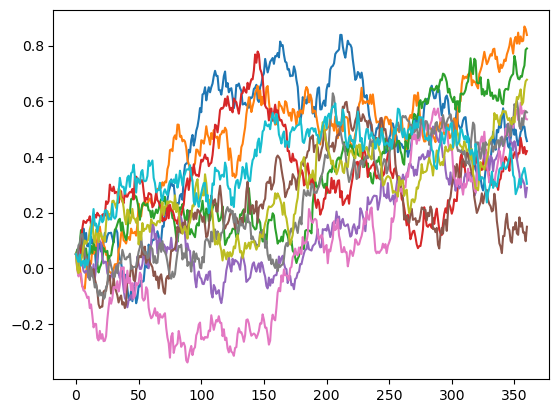

In [15]:
for i in range(10):
    plt.plot(range(HW.step_size+1), HW.short_rate_paths()[i])

For each $t_i$, the mean of $r(t_i)$ should converge to $E\{r(t_i) | \mathcal{F}_{0}\}$. For convenience, `mean_short_rate` and `E_rt` are defined to represent the mean of $r(t_i)$ and $E\{r(t_i) | \mathcal{F}_{0}\}$ respectively.

In [16]:
HW.mean_short_rate.formula

def mean_short_rate():
    """The means of generated short rates

    Returns, as a numpy array, the means of short rates of all scenarios
    for all :math:`t_i`.
    This should converge to the theoretical variances
    calculated by :meth:`E_rt`.

    .. seealso::
        * :meth:`short_rate`
        * :meth:`E_rt`
    """
    return np.array([np.mean(short_rate(i)) for i in range(step_size + 1)])

In [17]:
HW.E_rt.formula

def E_rt():
    """The expected values of :math:`r(t_i)` at time 0 for all :math:`t_i`.

    Returns, in a numpy array, the expected values of
    :math:`r(t_i)` for all :math:`t_i`.
    Calculated as :math:`E\{r(t_i) | \mathcal{F}_{0}\}`.

    .. seealso::

       * :meth:`E_rt_s`

    """
    return np.array([E_rt_s(0, i)[0] for i in range(step_size + 1)])

The chart below compares the mean of $r(t_i)$ against $E\{r(t_i) | \mathcal{F}_{0}\}$ with 1000 scenarios. The chart looks similar to Balaraman's analysis. The mean converges pretty well during the first 20 years (240 steps), but diverges from the expectation around the 300th step.

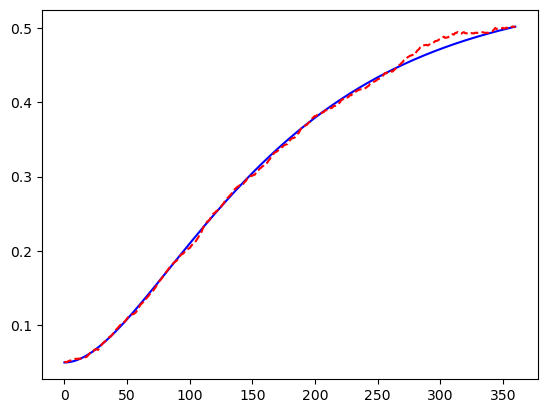

In [18]:
HW.scen_size = 1000
plt.plot(range(HW.step_size + 1), HW.E_rt(), "b-")
plt.plot(range(HW.step_size + 1), HW.mean_short_rate(), "r--")

The chart below is with 10,000 scenarios. The divergence dissapears and the mean fits the expectation much better.

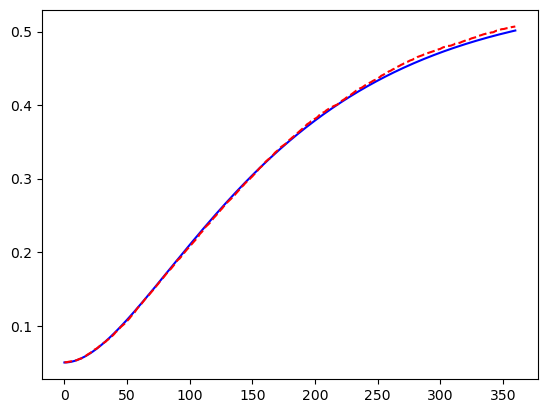

In [19]:
HW.scen_size = 10000
HW.a = 0.1
HW.sigma = 0.1
plt.plot(range(HW.step_size + 1), HW.E_rt(), "b-")
plt.plot(range(HW.step_size + 1), HW.mean_short_rate(), "r--")

In the same manner as the mean, for each $t_i$, the variance of $r(t_i)$ should converge to $Var\{r(t_i) | \mathcal{F}_{0}\}$. For convenience, `var_short_rate` and `Var_rt` are defined to represent the variance of $r(t_i)$ and $Var\{r(t_i) | \mathcal{F}_{0}\}$ respectively.

In [20]:
HW.var_short_rate.formula

def var_short_rate():
    """Variance of generated short rates

    Returns, as a vector in a numpy array, the variances of
    the generated short rates for all :math:`t_i`.
    This should converge to the theoretical variances
    calculated by :meth:`Var_rt`.

    .. seealso::
        * :meth:`short_rate`
        * :meth:`Var_rt`

    """
    return np.array([np.var(short_rate(i)) for i in range(step_size + 1)])

In [21]:
HW.Var_rt.formula

def Var_rt():
    r"""The variance of :math:`r(t_i)` at time 0 for all :math:`t_i`.

    Returns, in a numpy array, the variance of
    :math:`r(t_i)` for all :math:`t_i`.
    Calculated as :math:`Var\{r(t_i) | \mathcal{F}_{0}\}`.

    .. seealso::
        * :meth:`Var_rt_s`
    """
    return np.array([Var_rt_s(0, i) for i in range(step_size + 1)])

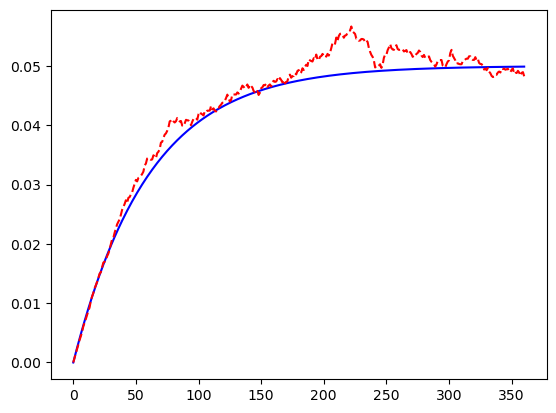

In [22]:
HW.scen_size = 1000
plt.plot(range(HW.step_size + 1), HW.Var_rt(), "b-")
plt.plot(range(HW.step_size + 1), HW.var_short_rate(), "r--")

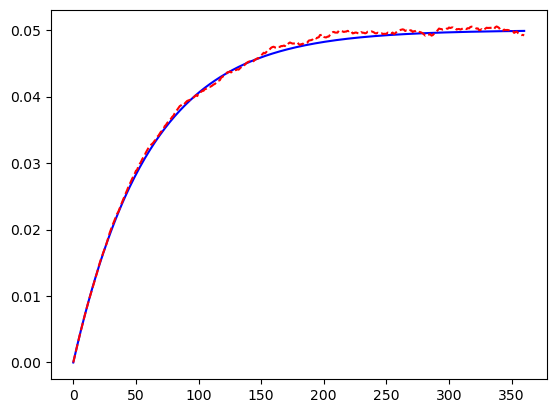

In [23]:
HW.scen_size = 10000
plt.plot(range(HW.step_size + 1), HW.Var_rt(), "b-")
plt.plot(range(HW.step_size + 1), HW.var_short_rate(), "r--")

## Simulating the discount factor

Along with $r(t_{i})$, the discount factor needs to be simulated. The discount factor is defined as $e^{-Y(t_i)}$ where

$$Y(t_i)=\int_0^{t_i}r(t)dt$$

For simplicity, we model $Y(t_i)$ as a descrete approximation to the integral:

$$\sum_{j=1}^{i}r(t_{j-1})(t_j-t_{j-1})$$

In [24]:
HW.accum_short_rate.formula

def accum_short_rate(i):
    r"""Accumulated short rates.

    a descrete approximation to the integral :math:`\int_0^{t_i}r(t)dt`,
    calculated as :math:`\sum_{j=1}^{i}r(t_{j-1})(t_j-t_{j-1})`

    .. seealso::
        * :meth:`disc_factor`
    """
    if i == 0:
        return np.full(scen_size, 0.0)
    else:
        dt = t_(i) - t_(i-1)
        return accum_short_rate(i-1) + short_rate(i-1) * dt

There is an alternative approach to simulate $Y(t_i)$ by using the fact that $Y(t_i)$ follows a normal distribution, and by simulating the joint distribution of $(r(t_i), Y(t_i))$ as suggested in [Monte Carlo Methods in Financial Engineering](https://link.springer.com/book/10.1007/978-0-387-21617-1). `accum_short_rate2` implements this alternative approach, althogh it does not have material impact on the discussion below.  

In [25]:
HW.accum_short_rate2.formula

def accum_short_rate2(i):
    r"""Alternative implementation of accumulated short rates.

    An alternative approach to simulate :math:`Y(t_i)=\int_0^{t_i}r(t)dt`
    by using the fact that :math:`Y(t_i)` follows a normal distribution,
    and by simulating the joint distribution of :math:`(r(t_i), Y(t_i))`,
    as suggested in Glasserman (2003).

    .. seealso::
        * :meth:`accum_short_rate`
        * :attr:`seed2`
        * Paul Glasserman (2003). Monte Carlo Methods in Financial Engineering
    """
    if i == 0:
        return np.full(scen_size, 0.0)
    else:
        t, T = t_(i-1), t_(i)
        dt = T - t
        cov = sigma**2/(2*a**2)*(1 + np.exp(-2*a*dt) -2 * np.exp(-a*dt))
        z1 = std_norm_rand(seed1)[:, i-1]
        z2 = std_norm_rand(seed2)[:, i-1]

        rho = cov / (Var_rt_s(i-1, i)**0.5 * V_t_T(i-1, i)**0.5)

        mean = B_t_T(i-1, i) * (short_rate(i-1) - alpha(i-1)) + np.log(mkt_zcb(i-1)/mkt_zcb(i)) + 0.5*(V_t_T(0, i)-V_t_T(0, i-1))
        return accu

`discount_factor` and `mean_disc_factor` are defined as follows.

In [26]:
HW.disc_factor.formula

def disc_factor(i):
    """Discount factors

    Returns, in a numpy array, the discount factors for
    cashflows at :math:`t_i` for all scenarios.
    Defined as::

        np.exp(-accum_short_rate(i))

    .. seealso::
        * accum_short_rate

    """
    return np.exp(-accum_short_rate(i))

In [27]:
HW.mean_disc_factor.formula

def mean_disc_factor():
    """Discount factor means

    Returns, as a numpy array, the mean of discount factors of all scenarios
    for each :math:`t_i`.

    .. seealso::
        * :meth:`disc_factor`
    """
    return np.array([np.mean(disc_factor(i)) for i in range(step_size + 1)])

The chart below compares the mean of the simulated discount factors against $P^M(0, t_i)$ with 1000 scenarios. The mean diverges from the expectation significantly after the 150th step.

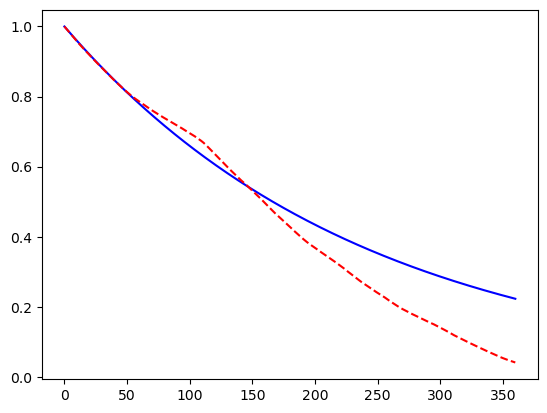

In [28]:
HW.scen_size = 1000
plt.plot(range(HW.step_size+1), [HW.mkt_zcb(i) for i in range(HW.step_size+1)], "b-")
plt.plot(range(HW.step_size+1), HW.mean_disc_factor(), "r--")

The chart shows the case of 10,000 scenarios. The stochastic mean does not converge well. Even with 100,000 scenarios, the convergence is still poor.

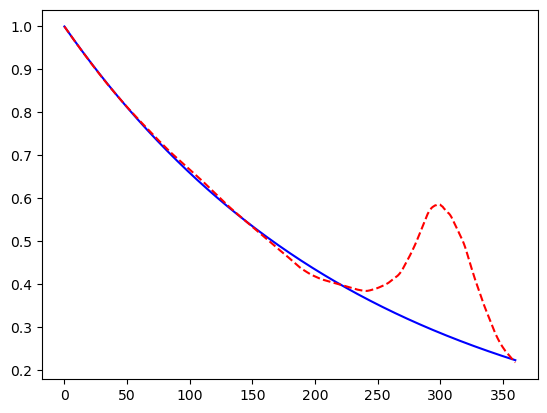

In [29]:
HW.scen_size = 10000
plt.plot(range(HW.step_size+1), [HW.mkt_zcb(i) for i in range(HW.step_size+1)], "b-")
plt.plot(range(HW.step_size+1), HW.mean_disc_factor(), "r--")

The charts below examine the convergence of the discount factor for various combinations of $\sigma$ and $a$, first by changing $\sigma$ and secondly by changing $a$.
As Balaraman's study shows, the convergence gets worse as $\sigma/a$ gets larger than 1, and gets better as $\sigma/a$ gets smaller than 1.

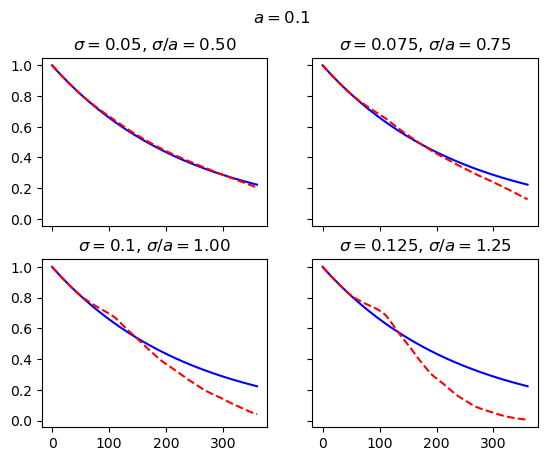

In [30]:
HW.scen_size = 1000

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle(r"$a=$" + str(HW.a))
for sigma, (h, v) in zip([0.05, 0.075, 0.1, 0.125], [(0, 0), (0, 1), (1, 0), (1, 1)]):
    HW.sigma = sigma
    axs[h, v].set_title(r"$\sigma=$" + str(sigma) +  r", $\sigma/a=$" + "%.2f" % (sigma/HW.a))
    axs[h, v].plot(range(HW.step_size+1), [HW.mkt_zcb(i) for i in range(HW.step_size+1)], "b-")
    axs[h, v].plot(range(HW.step_size+1), HW.mean_disc_factor(), "r--")

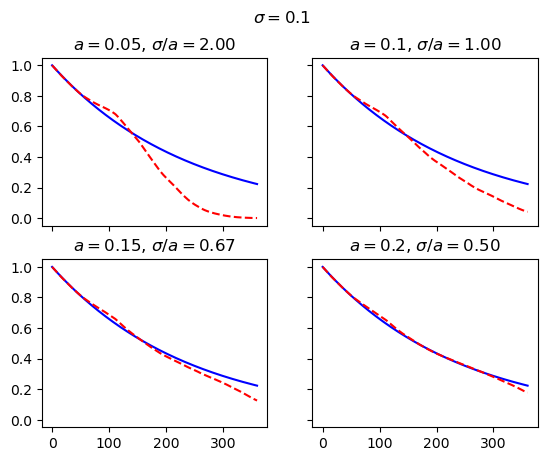

In [31]:
HW.scen_size = 1000
HW.sigma = 0.1

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle(r"$\sigma=$" + str(HW.sigma))
for a, (h, v) in zip([0.05, 0.1, 0.15, 0.2], [(0, 0), (0, 1), (1, 0), (1, 1)]):
    HW.a = a
    axs[h, v].set_title(r"$a=$" + str(a) +  r", $\sigma/a=$" + "%.2f" % (HW.sigma/HW.a))
    axs[h, v].plot(range(HW.step_size+1), [HW.mkt_zcb(i) for i in range(HW.step_size+1)], "b-")
    axs[h, v].plot(range(HW.step_size+1), HW.mean_disc_factor(), "r--")